# Imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from nltk.corpus import wordnet as wn # Import wordnet


In [ ]:
!pip install nltk
import nltk

In [ ]:
#run this only once
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download all required NLTK data
needed_nltk_data = ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger']
for item in needed_nltk_data:
    try:
        nltk.download(item)
    except:
        print(f"Could not download {item}, but continuing anyway...")

print("NLTK data download complete!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


NLTK data download complete!


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Model 1



In [ ]:
import pandas as pd

ratings = pd.read_csv('Ratings.csv')
articles = pd.read_csv('Articles.csv')


ratings.head(), articles.head()

(   Researcher_Id  article_Id  rating
 0              4         707       1
 1              4         710       1
 2              4         722       1
 3              4         756       1
 4              4         757       1,
    article.id                                              title  \
 0           4  comparative assessment of largescale data sets...   
 1          15         collective dynamics of smallworld networks   
 2          16  network motifs simple building blocks of compl...   
 3          17  authoritative sources in a hyperlinked environ...   
 4          24                     classes of smallworld networks   
 
                                             abstract  
 0  Comprehensive protein protein interaction maps...  
 1  Networks of coupled dynamical systems have bee...  
 2  Complex networks are studied across many field...  
 3  The network structure of a hyperlinked environ...  
 4  We study the statistical properties of a varie...  )

In [ ]:
articles.rename(columns={'article.id': 'article_Id'}, inplace=True)

merged_dataset = pd.merge(ratings, articles, left_on='article_Id', right_on='article_Id',how='inner')

merged_dataset.head()

,Researcher_Id,article_Id,rating,title,abstract
0,4,707,1,formal ontology and information systems,Research on ontology is becoming increasingly ...
1,4,710,1,a translation approach to portable ontology sp...,To support the sharing and reuse of formally r...
2,4,722,1,ontologies a silver bullet for knowledge manag...,{Ontologies have been developed and investigat...
3,4,756,1,the semantic web,The entertainment system was belting out the B...
4,4,757,1,business process execution language for web se...,This document defines a notation for specifyin...


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

#create a matrix for user-item interaction
userItemMatrix= ratings.pivot_table(index='Researcher_Id', columns='article_Id', values='rating', fill_value=0)

#compute similarity
item_sim = cosine_similarity(userItemMatrix.T)

item_sim_df = pd.DataFrame(item_sim, index=userItemMatrix.columns, columns=userItemMatrix.columns)


In [ ]:
vectorizer = CountVectorizer(stop_words ='english', max_features = 2000)
Xarticles = vectorizer.fit_transform(articles['abstract'])


In [ ]:
# preparing training data
positives = merged_dataset[['Researcher_Id', 'article_Id', 'abstract']].drop_duplicates()
positives['label'] = 1

all_articles = set(articles['article_Id'])
# Balanced negative sampling
negative_sample_ratio = 1
negatives = []
for researcher in ratings['Researcher_Id'].unique():
    interacted = set(ratings[ratings['Researcher_Id'] == researcher]['article_Id'])
    non_interacted = list(all_articles - interacted)
    negatives.extend([(researcher, article, 0)
                      for article in non_interacted[:int(len(interacted) * negative_sample_ratio)]])

negativeDf = pd.DataFrame (negatives, columns = ['Researcher_Id','article_Id','label'])
negativeDf = pd.merge(negativeDf, articles, left_on='article_Id', right_on='article_Id',how='inner')

trainData = pd.concat([positives, negativeDf])

X= vectorizer.transform(trainData['abstract'])
y= trainData['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Extract feature names from CountVectorizer
feature_names = vectorizer.get_feature_names_out()


In [ ]:
nb= MultinomialNB()
nb.fit(X,y)

y_pred = nb.predict(X_test)

In [ ]:
print("Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")


Naive Bayes Performance:
Accuracy: 0.9811
Precision: 0.9730
Recall: 0.9908
F1-Score: 0.9818


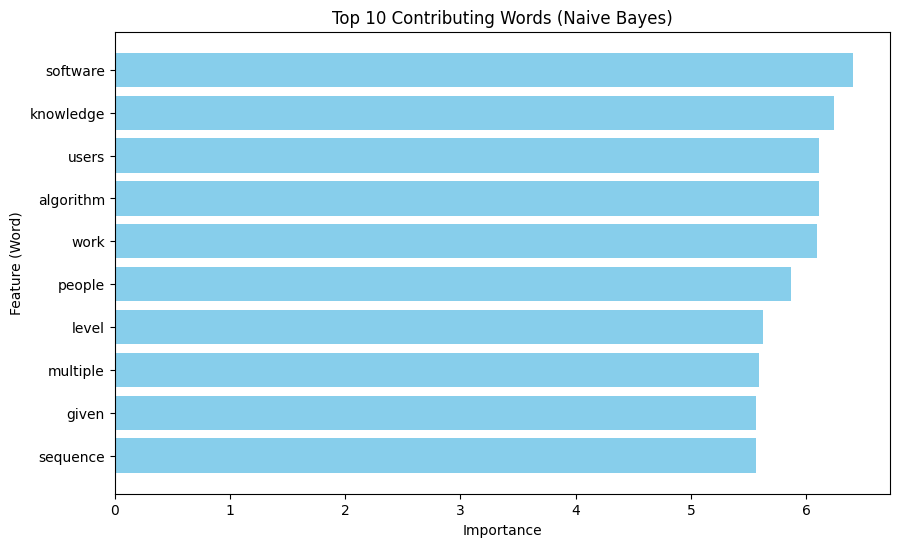

In [ ]:
# Compute feature importance for Naive Bayes
nb_importance = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]  # Log-probability difference

# Plot for Naive Bayes (Top 10 Features)
plot_feature_importance(feature_names, nb_importance, model_name='Naive Bayes')


In [ ]:
lr = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)

In [ ]:
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_predict):.4f}")
print(f"Precision: {precision_score(y_test, y_predict):.4f}")
print(f"Recall: {recall_score(y_test, y_predict):.4f}")
print(f"F1-Score: {f1_score(y_test, y_predict):.4f}")



Logistic Regression Performance:
Accuracy: 0.9934
Precision: 1.0000
Recall: 0.9872
F1-Score: 0.9935


In [ ]:
# Feature importance for Logistic Regression (absolute coefficients)
lr_importance = np.abs(lr.coef_[0])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = lr.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       515
           1       1.00      0.99      0.99       545

    accuracy                           0.99      1060
   macro avg       0.99      0.99      0.99      1060
weighted avg       0.99      0.99      0.99      1060

Confusion Matrix:
 [[515   0]
 [  7 538]]


In [ ]:
def recommend_articles(researcher_id, top_n=5, model='nb'):
    # Ensure 'text' column exists
    if 'text' not in articles.columns:
        articles['text'] = (articles['title'] + ' ' + articles['abstract']).fillna('')

    # Articles the researcher has not interacted with
    interacted_articles = set(ratings[ratings['Researcher_Id'] == researcher_id]['article_Id'])
    candidate_articles = articles[~articles['article_Id'].isin(interacted_articles)].copy()

    # Score candidates using the selected model
    X_candidates = vectorizer.transform(candidate_articles['text'])
    if model == 'nb':
        candidate_articles.loc[:, 'score'] = nb.predict_proba(X_candidates)[:, 1]
    elif model == 'lr':
        candidate_articles.loc[:, 'score'] = lr.predict_proba(X_candidates)[:, 1]
    else:
        raise ValueError("Invalid model! Choose 'nb' or 'lr'.")

    # Recommend top articles
    recommendations = candidate_articles.sort_values('score', ascending=False).head(top_n)
    return recommendations[['article_Id', 'title', 'score']]


In [ ]:
## example

researcherId= 2

nb_recommendations= recommend_articles(researcherId, top_n=6, model='nb')

print("\nNaive Bayes Recommendations:")
print(nb_recommendations)

lr_recommendations = recommend_articles(researcherId, top_n=6, model='lr')
print("\nLogistic Regression Recommendations:")
print(lr_recommendations)


Naive Bayes Recommendations:
      article_Id                                              title  score
1130        6945         randomeffects models for longitudinal data    1.0
1508        9625  bayesian inference with probabilistic populati...    1.0
1502        9601  datadriven modelling of signaltransduction net...    1.0
1503        9604  locating mammalian transcription factor bindin...    1.0
1504        9606     best practice in primary care pathology review    1.0
1505        9617  longterm motor cortex plasticity induced by an...    1.0

Logistic Regression Recommendations:
      article_Id                                              title     score
2092       14984  purification of proteins associated with speci...  1.000000
373         1920                               software engineering  1.000000
1851       12446         chromatin modifications and their function  1.000000
2196       16046            how to choose a good scientific problem  1.000000
1888       12827 

In [ ]:
nb_recommendations['model']= 'Naive Bayes'
lr_recommendations['model']= 'Logistic Regression'

# Combine the two DataFrames
all_recommendations = pd.concat([nb_recommendations, lr_recommendations])

# Reset index for consistent handling
all_recommendations.reset_index(drop=True, inplace=True)

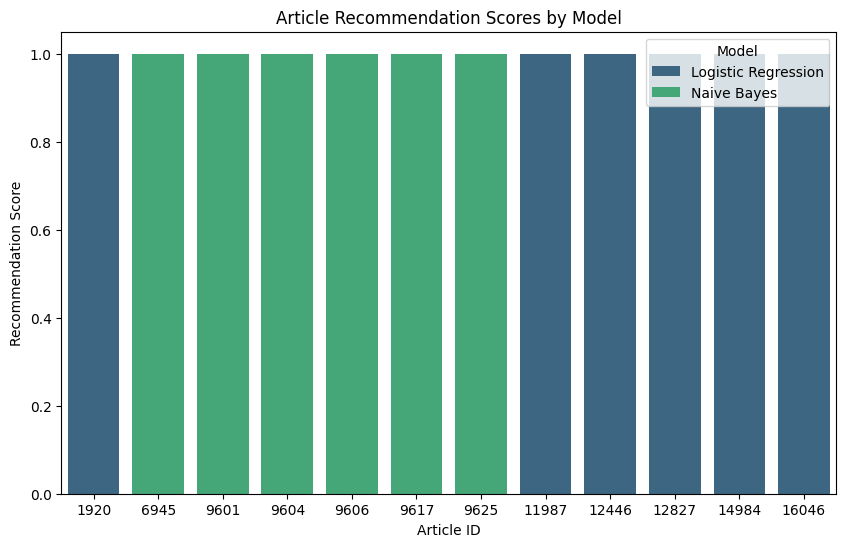

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Bar plot for article scores by model
plt.figure(figsize=(10, 6))
sns.barplot(data=all_recommendations, x='article_Id', y='score', hue='model', palette='viridis')
plt.title('Article Recommendation Scores by Model')
plt.xlabel('Article ID')
plt.ylabel('Recommendation Score')
plt.legend(title='Model')
plt.show()

In [ ]:
def plot_feature_importance(features, importance, model_name):
    # Get top 10 features
    sorted_idx = np.argsort(importance)[-10:]  # Indices of top 10 features
    sorted_features = [features[i] for i in sorted_idx]  # Top 10 feature names
    sorted_importance = importance[sorted_idx]  # Top 10 importance values

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.title(f'Top 10 Contributing Words ({model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature (Word)')
    plt.show()

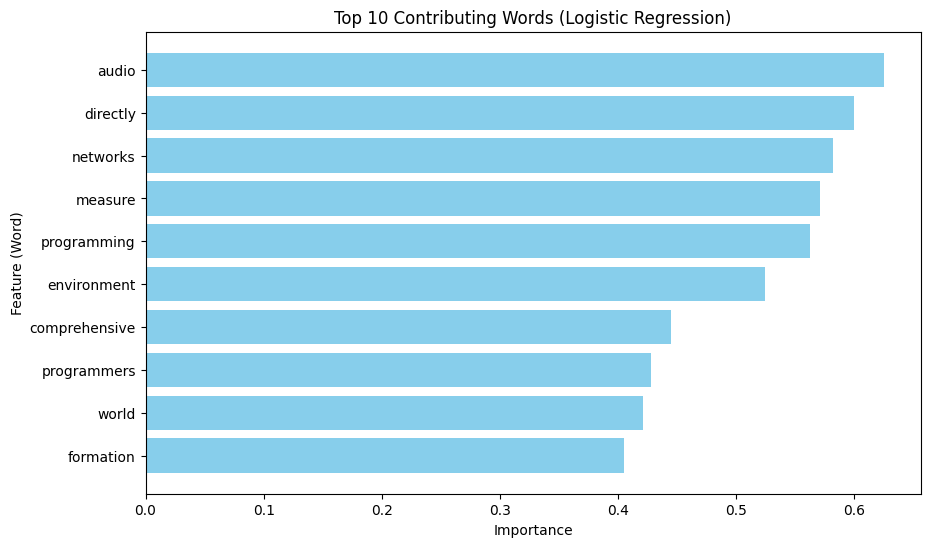

In [ ]:
# Plot for Logistic Regression
plot_feature_importance(feature_names, lr_importance, model_name='Logistic Regression')


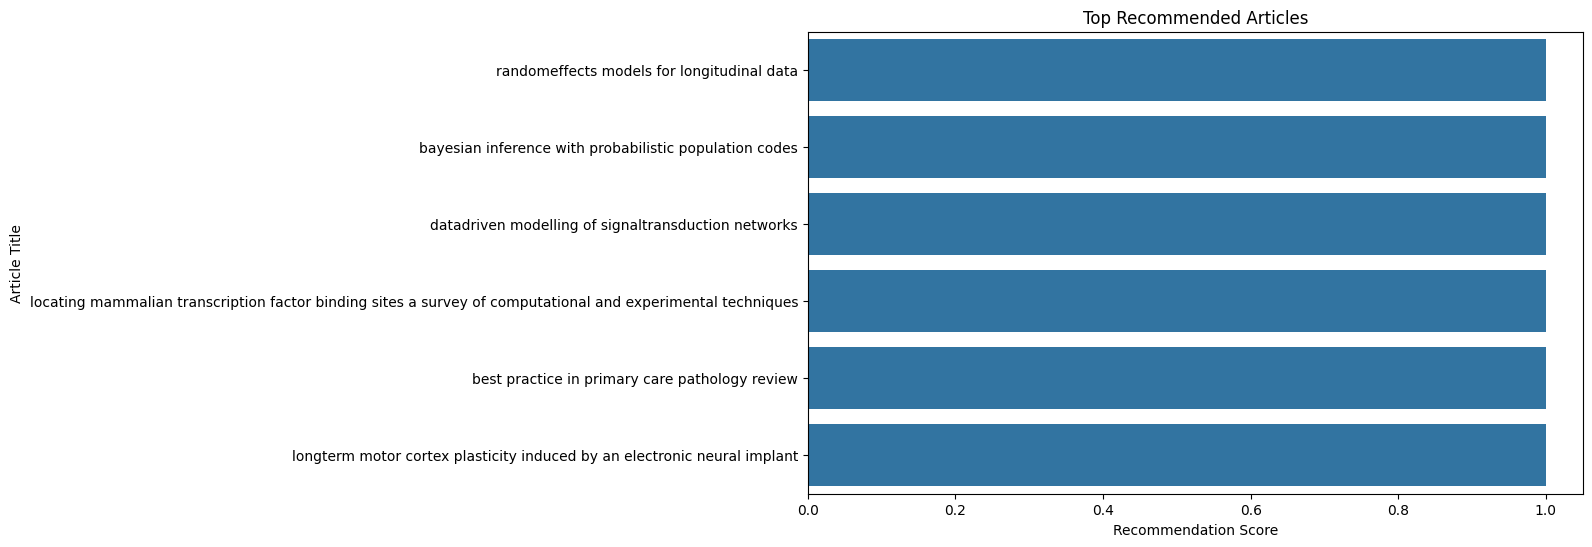

In [ ]:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='title', data=nb_recommendations.sort_values('score', ascending=False))
    plt.title('Top Recommended Articles')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Article Title')
    plt.show()

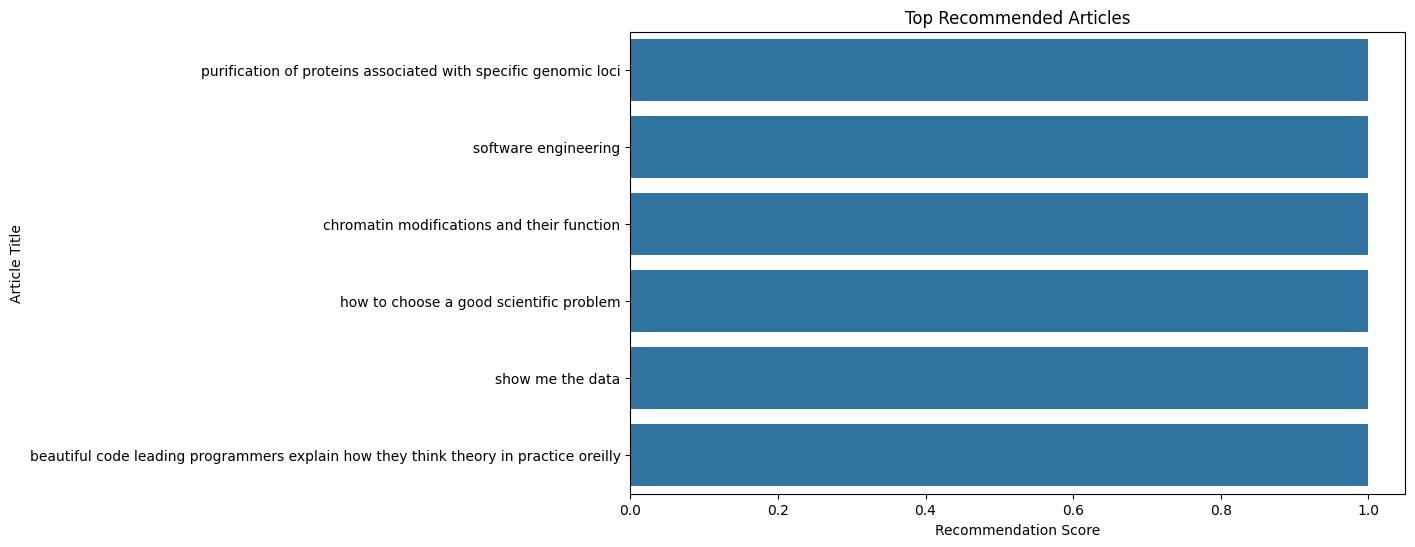

In [ ]:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='title', data=lr_recommendations.sort_values('score', ascending=False))
    plt.title('Top Recommended Articles')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Article Title')
    plt.show()

# Model 2

In [ ]:
class EnhancedArticleRecommender:
    def __init__(self):
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')

        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.vectorizer = None
        self.scaler = StandardScaler()
        self.models = {}
        self.svd = TruncatedSVD(n_components=100)
        self.isolation_forest = IsolationForest(contamination=0.1, random_state=42)

    def preprocess_text(self, text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\d+', 'NUM', text)

        tokens = word_tokenize(text)
        processed_tokens = []
        for token in tokens:
            if token not in self.stop_words and len(token) > 2:
                lemma = self.lemmatizer.lemmatize(token)
                lemma = self.lemmatizer.lemmatize(lemma, pos='v')
                processed_tokens.append(lemma)

        return ' '.join(processed_tokens)

    def extract_advanced_features(self, text, title):
        sentences = nltk.sent_tokenize(str(text))
        words = word_tokenize(str(text))
        title_words = word_tokenize(str(title))

        word_freq = Counter(words)
        unique_words = len(word_freq)

        features = {
            'word_count': len(words),
            'char_count': len(str(text)),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
            'special_char_count': len([c for c in str(text) if c in string.punctuation]),
            'numeric_count': len([c for c in str(text) if c.isdigit()]),
            'sentence_count': len(sentences),
            'avg_sentence_length': len(words) / len(sentences) if sentences else 0,
            'title_word_count': len(title_words),
            'title_abstract_overlap': len(set(title_words) & set(words)) / len(set(title_words)) if title_words else 0,
            'unique_words_ratio': unique_words / len(words) if words else 0,
            'stopwords_ratio': len([w for w in words if w.lower() in self.stop_words]) / len(words) if words else 0,
            'rare_words_ratio': len([w for w in words if word_freq[w] == 1]) / len(words) if words else 0,
            'common_words_ratio': len([w for w in words if word_freq[w] > 5]) / len(words) if words else 0
        }

        return features

    def get_article_features(self, articles_df):
        processed_texts = (articles_df['title'] + ' ' + articles_df['abstract']).apply(self.preprocess_text)
        text_features = self.vectorizer.transform(processed_texts)

        additional_features = []
        for _, row in articles_df.iterrows():
            features = self.extract_advanced_features(row['abstract'], row['title'])
            additional_features.append(features)

        additional_features_df = pd.DataFrame(additional_features)
        additional_features_scaled = self.scaler.transform(additional_features_df)

        return hstack([text_features, csr_matrix(additional_features_scaled)]).toarray()

    def create_synthetic_samples(self, articles_df, ratings_df, article_features, negative_ratio=1.5):
        researcher_articles = ratings_df.groupby('Researcher_Id')['article_Id'].apply(set).to_dict()
        all_article_ids = set(articles_df['article.id'])

        synthetic_samples = []
        for researcher_id, rated_articles in researcher_articles.items():
            potential_negatives = all_article_ids - rated_articles

            if potential_negatives:
                n_synthetic = int(len(rated_articles) * negative_ratio)

                negative_indices = [
                    articles_df[articles_df['article.id'] == aid].index[0]
                    for aid in potential_negatives
                ]

                negative_features = article_features[negative_indices]

                outlier_scores = self.isolation_forest.fit_predict(negative_features)

                negative_candidates = pd.DataFrame({
                    'article_id': list(potential_negatives),
                    'outlier_score': outlier_scores
                })

                selected_negatives = negative_candidates.nsmallest(n_synthetic, 'outlier_score')['article_id']
                synthetic_samples.extend([
                    (researcher_id, article_id, 0)
                    for article_id in selected_negatives
                ])

        return pd.DataFrame(synthetic_samples, columns=['Researcher_Id', 'article_Id', 'rating'])

    def fit(self, articles_df, ratings_df):
        print("Starting enhanced training process...")

        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.95,
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True
        )

        print("Extracting features...")
        processed_texts = (articles_df['title'] + ' ' + articles_df['abstract']).apply(self.preprocess_text)
        text_features = self.vectorizer.fit_transform(processed_texts)

        additional_features = []
        for _, row in articles_df.iterrows():
            features = self.extract_advanced_features(row['abstract'], row['title'])
            additional_features.append(features)

        additional_features_df = pd.DataFrame(additional_features)
        additional_features_scaled = self.scaler.fit_transform(additional_features_df)

        all_features = hstack([text_features, csr_matrix(additional_features_scaled)]).tocsr()

        print("Performing dimensionality reduction...")
        reduced_features = self.svd.fit_transform(all_features)
        min_max_scaler = MinMaxScaler()
        reduced_features = min_max_scaler.fit_transform(reduced_features)

        print("Generating synthetic samples...")
        synthetic_negatives = self.create_synthetic_samples(articles_df, ratings_df, reduced_features)
        enhanced_ratings_df = pd.concat([ratings_df, synthetic_negatives])

        print("Preparing training data...")
        X = []
        y = []
        article_id_to_idx = pd.Series(articles_df.index, index=articles_df['article.id'])

        for _, row in enhanced_ratings_df.iterrows():
            try:
                article_idx = article_id_to_idx[row['article_Id']]
                X.append(reduced_features[article_idx])
                y.append(row['rating'])
            except KeyError:
                continue

        X = np.vstack(X)
        y = np.array(y)

        print("Training models with cross-validation...")
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        models = {
            'naive_bayes': MultinomialNB(alpha=0.01, fit_prior=True),
            'logistic_regression': LogisticRegression(
                C=0.1,
                max_iter=1000,
                class_weight='balanced',
                penalty='l1',
                solver='saga',
                random_state=42
            )
        }

        results = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
                  for name in models.keys()}

        for name, model in models.items():
            print(f"Training {name}...")

            for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
                results[name]['precision'].append(precision_score(y_test, y_pred))
                results[name]['recall'].append(recall_score(y_test, y_pred))
                results[name]['f1'].append(f1_score(y_test, y_pred))

            model.fit(X, y)
            self.models[name] = model

            for metric in results[name]:
                results[name][metric] = np.mean(results[name][metric])

            print(f"{name} results:")
            for metric, value in results[name].items():
                print(f"{metric}: {value:.4f}")

        print("Training complete!")
        return results

    def plot_model_comparison(self, results):

        metrics = ['accuracy', 'precision', 'recall', 'f1']
        naive_bayes_scores = [results['naive_bayes'][metric] for metric in metrics]
        logistic_regression_scores = [results['logistic_regression'][metric] for metric in metrics]

        x = np.arange(len(metrics))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width/2, naive_bayes_scores, width, label='Naive Bayes', color='skyblue')
        ax.bar(x + width/2, logistic_regression_scores, width, label='Logistic Regression', color='orange')

        ax.set_xlabel('Metrics', fontsize=14)
        ax.set_ylabel('Score', fontsize=14)
        ax.set_title('Model Performance Comparison', fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend(fontsize=12)

        plt.tight_layout()
        plt.show()

    def recommend(self, articles_df, ratings_df, top_n=5):
      researcher_id = 263
      rated_articles = set(ratings_df[ratings_df['Researcher_Id'] == researcher_id]['article_Id'])
      unrated_articles = articles_df[~articles_df['article.id'].isin(rated_articles)]
      if unrated_articles.empty:
          print(f"No articles to recommend for researcher {researcher_id}.")
          return pd.DataFrame()

      article_features = self.get_article_features(unrated_articles)

      reduced_features = self.svd.transform(article_features)

      reduced_features = MinMaxScaler().fit_transform(reduced_features)

      log_reg_model = self.models['logistic_regression']
      probabilities = log_reg_model.predict_proba(reduced_features)[:, 1]

      unrated_articles = unrated_articles.copy()
      unrated_articles['score'] = probabilities

      top_recommendations = unrated_articles.sort_values('score', ascending=False).head(top_n)

      print(f"Top {top_n} recommendations for researcher {researcher_id}:")
      return top_recommendations[['article.id', 'title', 'score']]

In [ ]:
articles_df = pd.read_excel('/content/Articles.xlsx')
ratings_df = pd.read_csv('Ratings.csv')

# Initialize and train the model
recommender = EnhancedArticleRecommender()
results = recommender.fit(articles_df, ratings_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Starting enhanced training process...
Extracting features...
Performing dimensionality reduction...
Generating synthetic samples...
Preparing training data...
Training models with cross-validation...
Training naive_bayes...
naive_bayes results:
accuracy: 0.5976
precision: 0.0000
recall: 0.0000
f1: 0.0000
Training logistic_regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

logistic_regression results:
accuracy: 0.8876
precision: 0.8665
recall: 0.8520
f1: 0.8591
Training complete!


In [ ]:
# Run the recommendation process
top_recommendations = recommender.recommend(articles_df, ratings_df, top_n=5)
print(top_recommendations)

Top 5 recommendations for researcher 263:
      article.id                                              title     score
1029        6189   empirical analysis of an evolving social network  0.998811
651         3604  time clocks and the ordering of events in a di...  0.998569
457         2392  recommending collaboration with social network...  0.998485
586         3089  comparative metagenomics of microbial communities  0.998253
1722       11254  the increasing dominance of teams in productio...  0.998165


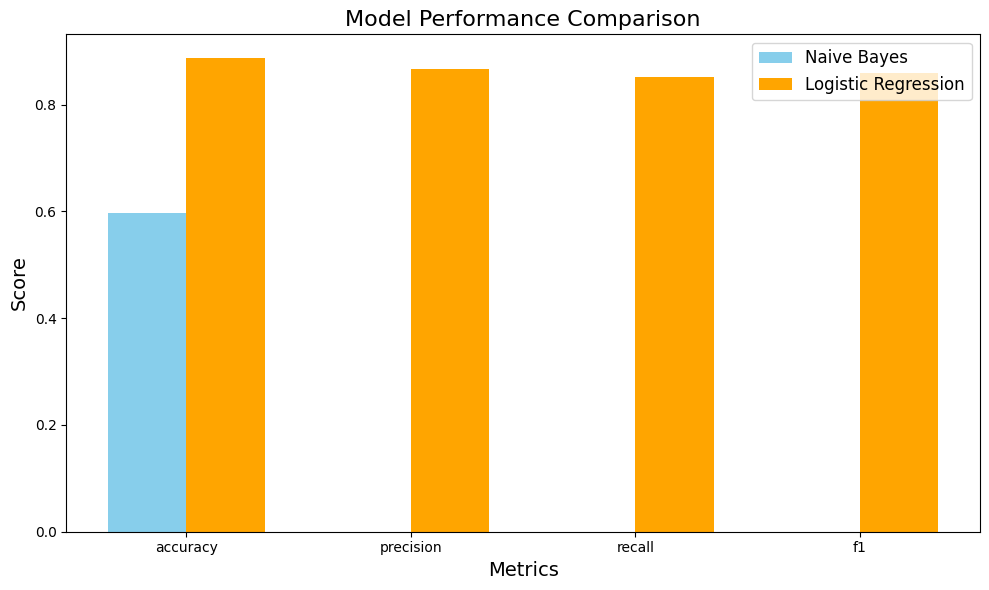

In [ ]:
recommender.plot_model_comparison(results)

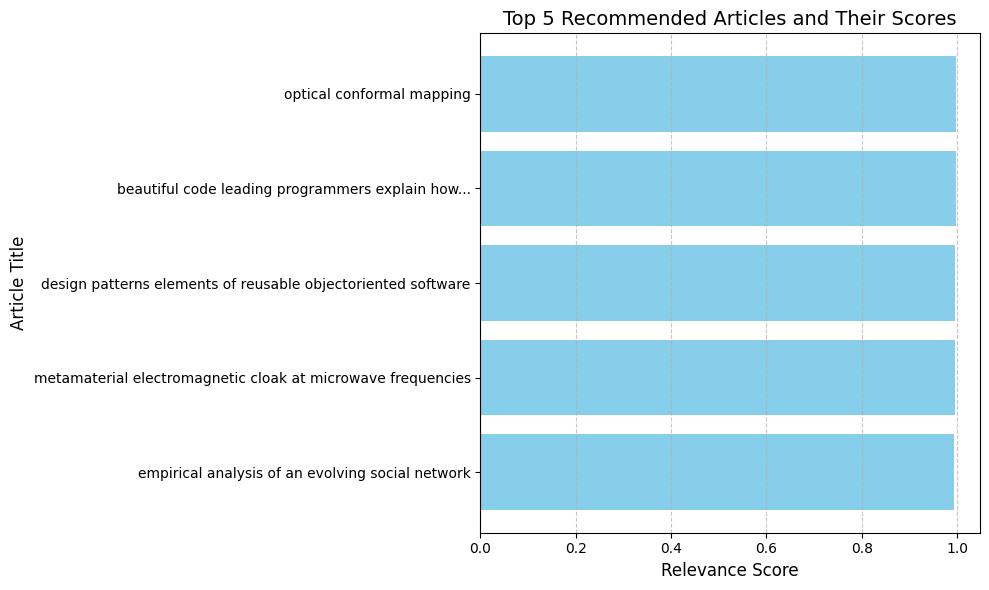

In [ ]:
top_5_articles = [
    {"article.id": 8990, "title": "optical conformal mapping", "score": 0.997961},
    {"article.id": 11987, "title": "beautiful code leading programmers explain how...", "score": 0.997718},
    {"article.id": 889, "title": "design patterns elements of reusable objectoriented software", "score": 0.995303},
    {"article.id": 12493, "title": "metamaterial electromagnetic cloak at microwave frequencies", "score": 0.994479},
    {"article.id": 6189, "title": "empirical analysis of an evolving social network", "score": 0.994170}
]

titles = [article["title"] for article in top_5_articles]
scores = [article["score"] for article in top_5_articles]


plt.figure(figsize=(10, 6))
plt.barh(titles, scores, color='skyblue')
plt.xlabel('Relevance Score', fontsize=12)
plt.ylabel('Article Title', fontsize=12)
plt.title('Top 5 Recommended Articles and Their Scores', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Model 3

In [ ]:
articles_df = pd.read_excel('Articles.xlsx')
ratings_df = pd.read_csv('Ratings.csv')

In [ ]:
import pandas as pd
import random

# Merge ratings with articles to ensure text data is included
ratings_merged = ratings_df.merge(articles_df, left_on='article_Id', right_on='article.id', how='inner')



In [ ]:
ratings_merged.head()

,Researcher_Id,article_Id,rating,article.id,title,abstract
0,4,707,1,707,formal ontology and information systems,Research on ontology is becoming increasingly ...
1,4,710,1,710,a translation approach to portable ontology sp...,To support the sharing and reuse of formally r...
2,4,722,1,722,ontologies a silver bullet for knowledge manag...,{Ontologies have been developed and investigat...
3,4,756,1,756,the semantic web,The entertainment system was belting out the B...
4,4,757,1,757,business process execution language for web se...,This document defines a notation for specifyin...


In [ ]:
# Identify all unique researcher IDs and article IDs
all_researchers = ratings_df['Researcher_Id'].unique()
all_articles = set(articles_df['article.id'].unique())


In [ ]:
# Create a list to store negative samples
negative_samples = []

# Generate negative samples for each researcher
for researcher in all_researchers:
    # Articles preferred by the researcher
    preferred_articles = set(ratings_df[ratings_df['Researcher_Id'] == researcher]['article_Id'])

    # Articles not preferred by the researcher
    non_preferred_articles = list(all_articles - preferred_articles)

    # Randomly select negative samples (same number as preferred articles, or fewer if not enough non-preferred articles)
    num_negative_samples = min(len(preferred_articles), len(non_preferred_articles))
    selected_negatives = random.sample(non_preferred_articles, num_negative_samples)

    # Add negative samples to the list
    for article_id in selected_negatives:
        negative_samples.append({'Researcher_Id': researcher, 'article_Id': article_id, 'rating': 0})




In [ ]:
# Convert the negative samples list into a DataFrame
negative_samples_df = pd.DataFrame(negative_samples)


In [ ]:
negative_samples_df.head()

,Researcher_Id,article_Id,rating
0,4,13815,0
1,4,7366,0
2,4,12402,0
3,4,1709,0
4,4,11712,0


In [ ]:
# Combine positive and negative samples
full_ratings = pd.concat([ratings_df, negative_samples_df], ignore_index=True)

# Shuffle the dataset
full_ratings = full_ratings.sample(frac=1, random_state=42).reset_index(drop=True)

# Merge the full_ratings with article text data for model input
final_dataset = full_ratings.merge(articles_df, left_on='article_Id', right_on='article.id', how='inner')



In [ ]:
# Display the first few rows of the final dataset
(final_dataset.head())

,Researcher_Id,article_Id,rating,article.id,title,abstract
0,89,4224,1,4224,biodiversity datadiversity,: Biodiversity is a data-intense science; draw...
1,204,778,1,778,global mapping of the yeast genetic interactio...,A genetic interaction network containing appro...
2,158,10044,1,10044,structure and evolution of online social networks,In this work; we consider the evolution of str...
3,283,8944,0,8944,metamaterials and negative refractive index,Recently; artificially constructed metamateria...
4,442,12012,0,12012,fileaccess characteristics of parallel scienti...,<p><b>Abstract</b>&#8212;Phenomenal improvemen...


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Split the dataset into training and testing
X = final_dataset['title']
y = final_dataset['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
# Fix: Ensure the 'text' column is a proper string for TF-IDF
final_dataset['text'] = final_dataset['title'].apply(lambda x: " ".join(x) if isinstance(x, list) else x) + " " + \
                        final_dataset['abstract'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
final_dataset['text'] = final_dataset['text'].astype(str)


In [ ]:
final_dataset['rating'].value_counts()

,count
rating,
1,2648
0,2648


In [ ]:
# Convert lists of tokens into strings
#X_train = X_train.apply(lambda tokens: ' '.join(tokens))
#X_test = X_test.apply(lambda tokens: ' '.join(tokens))

# Verify the transformation
print(X_train.head())


290     neural correlates of decision variables in par...
4882    datadriven modelling of signaltransduction net...
3069            pervasive computing vision and challenges
1515    ceph a scalable highperformance distributed fi...
2491    an improved general amino acid replacement matrix
Name: title, dtype: object


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:

# Initialize models
models = {
    'Naive Bayes (MultinomialNB)': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42)
}

# Store results
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_tfidf)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store metrics
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    # Print classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print("=" * 80)

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T




Classification Report for Naive Bayes (MultinomialNB):

              precision    recall  f1-score   support

           0       0.40      0.41      0.40       795
           1       0.40      0.39      0.39       794

    accuracy                           0.40      1589
   macro avg       0.40      0.40      0.40      1589
weighted avg       0.40      0.40      0.40      1589

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.40      0.39      0.39       795
           1       0.40      0.41      0.41       794

    accuracy                           0.40      1589
   macro avg       0.40      0.40      0.40      1589
weighted avg       0.40      0.40      0.40      1589



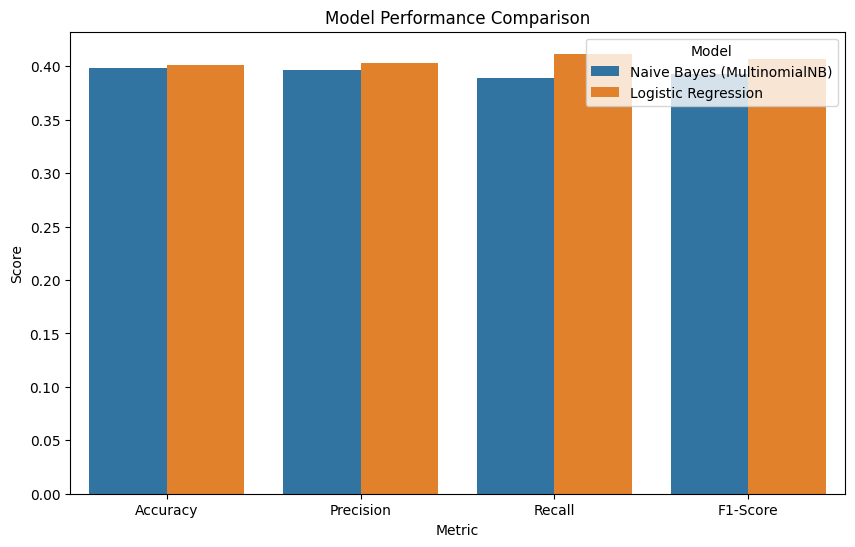

In [ ]:
# Plot the performance comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score'),
            x='Metric', y='Score', hue='index')
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model')
plt.show()


In [ ]:
# Personalized Recommendations
def recommend_articles(model, researcher_id, top_n=5):
    """
    Recommends top N articles for a given researcher, excluding articles they have already rated.
    """
    # Get articles the researcher has already rated
    rated_articles = final_dataset[final_dataset['Researcher_Id'] == researcher_id]['article_Id'].unique()

    # Get unrated articles
    unrated_articles = final_dataset[~final_dataset['article_Id'].isin(rated_articles)].drop_duplicates(subset=['article_Id'])

    # Transform text data of unrated articles
    unrated_text_tfidf = tfidf.transform(unrated_articles['text'])

    # Predict probabilities for unrated articles
    unrated_articles['predicted_score'] = model.predict_proba(unrated_text_tfidf)[:, 1]

    # Rank articles by predicted score
    recommendations = unrated_articles.sort_values(by='predicted_score', ascending=False).head(top_n)

    return recommendations[['article_Id', 'predicted_score', 'text']]

# Generate recommendations for a specific researcher (example: researcher_id = 4)
best_model_name = results_df['F1-Score'].idxmax()
best_model = models[best_model_name]
recommendations = recommend_articles(best_model, researcher_id=4)



In [ ]:
print(f"\nTop 5 Recommendations for Researcher ID 4 using {best_model_name}:\n")
(recommendations.head())



Top 5 Recommendations for Researcher ID 4 using Logistic Regression:



,article_Id,predicted_score,text
1717,7546,0.748480,usage patterns of collaborative tagging system...
1104,3982,0.745847,the structure of collaborative tagging systems...
1046,6217,0.723140,playing and making games for learning instruct...
2787,1968,0.721185,combinatorial optimization algorithms and comp...
4863,7858,0.718084,flexibility and conformational entropy in prot...


# Model 4

In [ ]:
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def get_antonym(word):
    """
    Function to find the antonym of a word using WordNet.
    If no antonym is found, it returns the word itself.
    """
    antonyms = []
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            if lemma.antonyms():
                antonyms.append(lemma.antonyms()[0].name())

    if antonyms:
        return antonyms[0]
    else:
        return word  # Return the word itself if no antonym is found

def negate_text_using_antonyms(text):
    """
    Function to negate text by replacing positive words with their antonyms.
    """
    # Tokenize the text
    words = word_tokenize(text)

    # Stopwords list to exclude common words
    stop_words = set(stopwords.words('english'))

    # Replace words with their antonyms where applicable
    negated_text = []
    for word in words:
        # Only negate the word if it is a non-stopword and has an antonym
        if word.lower() not in stop_words:
            antonym = get_antonym(word.lower())
            negated_text.append(antonym)
        else:
            negated_text.append(word)

    # Join back the words into a single string
    return " ".join(negated_text)

# Example usage
text = "The car is very fast and amazing!"
negated_text = negate_text_using_antonyms(text)
print("Original:", text)
print("Negated:", negated_text)


Original: The car is very fast and amazing!
Negated: The car is very slow and amazing !


In [ ]:
articles_df = pd.read_excel('Articles.xlsx')
ratings_df = pd.read_csv('Ratings.csv')

In [ ]:
import pandas as pd
import random

# Merge ratings with articles to ensure text data is included
ratings_merged = ratings_df.merge(articles_df, left_on='article_Id', right_on='article.id', how='inner')



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords



# Function to get antonyms using WordNet
def get_antonym(word):
    """
    Function to find the antonym of a word using WordNet.
    If no antonym is found, it returns the word itself.
    """
    antonyms = []
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            if lemma.antonyms():
                antonyms.append(lemma.antonyms()[0].name())

    if antonyms:
        return antonyms[0]
    else:
        return word  # Return the word itself if no antonym is found

# Function to negate text by replacing positive words with their antonyms
def negate_text_using_antonyms(text):
    """
    Function to negate text by replacing positive words with their antonyms.
    """
    # Tokenize the text
    words = word_tokenize(text)

    # Stopwords list to exclude common words
    stop_words = set(stopwords.words('english'))

    # Replace words with their antonyms where applicable
    negated_text = []
    for word in words:
        # Only negate the word if it is a non-stopword and has an antonym
        if word.lower() not in stop_words:
            antonym = get_antonym(word.lower())
            negated_text.append(antonym)
        else:
            negated_text.append(word)

    # Join back the words into a single string
    return " ".join(negated_text)

# Applying negation to the `final_dataset.head()`
def create_negative_samples(dataset):
    negative_samples = []

    for index, row in dataset.iterrows():
        # Original positive sample
        original_title = row['title']
        # Negated sample
        negated_title = negate_text_using_antonyms(original_title)

        # Create a negative sample with rating 0
        negative_samples.append({
            'Researcher_Id': row['Researcher_Id'],
            'article_Id': row['article_Id'],
            'rating': 0,  # Assuming negative samples have a rating of 0
            'title': negated_title,
            'abstract': row['abstract']
        })

    return negative_samples

# Example: Apply to the first 5 rows of the dataset (final_dataset.head())
negative_samples = create_negative_samples(final_dataset.head())

# Convert the list of negative samples to DataFrame
negative_samples_df = pd.DataFrame(negative_samples)



In [ ]:
# Display the new DataFrame with negated titles
(negative_samples_df)


,Researcher_Id,article_Id,rating,title,abstract
0,89,4224,0,biodiversity datadiversity,: Biodiversity is a data-intense science; draw...
1,204,778,0,global mapping of the yeast genetic interactio...,A genetic interaction network containing appro...
2,158,10044,0,structure and devolution of off-line unsocial ...,In this work; we consider the evolution of str...
3,283,8944,0,metamaterials and affirmative refractive index,Recently; artificially constructed metamateria...
4,442,12012,0,fileaccess characteristics of perpendicular un...,<p><b>Abstract</b>&#8212;Phenomenal improvemen...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Example: Splitting dataset into training and testing (80/20 split)
X = final_dataset[['title', 'abstract']]  # Feature columns
y = final_dataset['rating']  # Target column (rating)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train['title'] + " " + X_train['abstract'])
X_test_tfidf = vectorizer.transform(X_test['title'] + " " + X_test['abstract'])


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
import numpy as np

def get_top_recommendations(model, X, researcher_id, num_recommendations=5):
    # Get all articles that the researcher has not rated (rating = 0)
    researcher_data = final_dataset[final_dataset['Researcher_Id'] == researcher_id]
    rated_articles = set(researcher_data['article_Id'])

    # Get prediction probabilities for all articles
    predictions = model.predict_proba(X)
    # Only recommend articles that the researcher hasn't rated
    recommended_articles = []

    for idx, pred in enumerate(predictions):
        article_id = final_dataset.iloc[idx]['article_Id']
        if article_id not in rated_articles:
            recommended_articles.append((article_id, pred[1]))  # (article_id, probability of liking)

    # Sort the articles by recommendation score (probability)
    recommended_articles.sort(key=lambda x: x[1], reverse=True)

    # Return top N recommendations
    return recommended_articles[:num_recommendations]

# Example: Get top 5 recommendations for a researcher (Researcher_Id = 89) using Naive Bayes
researcher_id = 89
top_recommendations_nb = get_top_recommendations(nb_model, X_test_tfidf, researcher_id)

# Example: Get top 5 recommendations for a researcher (Researcher_Id = 89) using Logistic Regression
top_recommendations_lr = get_top_recommendations(lr_model, X_test_tfidf, researcher_id)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluate Naive Bayes model
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average='binary')

# Evaluate Logistic Regression model
y_pred_lr = lr_model.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')

print(f"Naive Bayes - Accuracy: {accuracy_nb}, Precision: {precision_nb}, Recall: {recall_nb}, F1-Score: {f1_nb}")
print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}, F1-Score: {f1_lr}")


Naive Bayes - Accuracy: 0.4047169811320755, Precision: 0.4018058690744921, Recall: 0.3272058823529412, F1-Score: 0.3606889564336373
Logistic Regression - Accuracy: 0.39716981132075474, Precision: 0.40083507306889354, Recall: 0.35294117647058826, F1-Score: 0.375366568914956


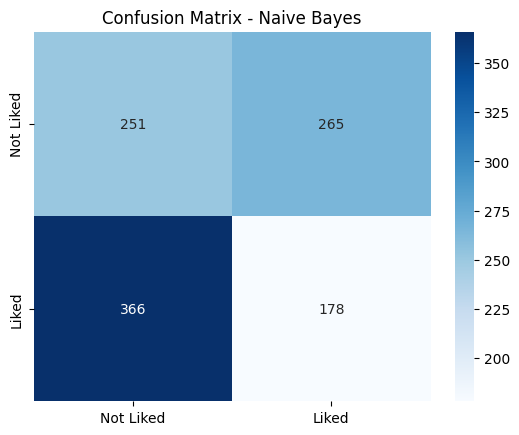

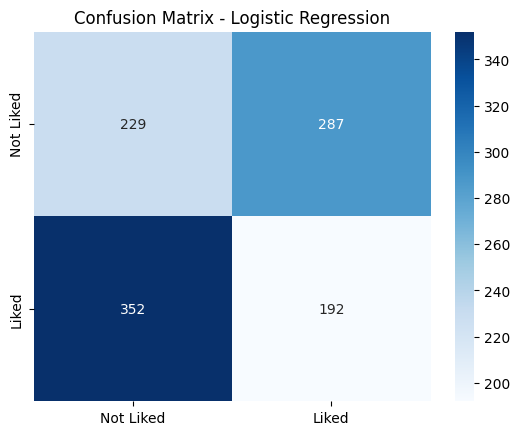

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
